# 1. 数据读取分析

In [5]:
import pandas as pd
import numpy as np
titanic=pd.read_csv("titanic/train.csv")
# 对数据进行一个大概统计，查看缺失值或是无意义值等
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 2. 数据预处理

In [6]:
# 发现age字段缺失，进行缺失值处理，填充中位数
titanic['Age']=titanic['Age'].fillna(titanic['Age'].median())
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# 将非数值型数据进行量化

# Sex量化
print(titanic['Sex'].unique())
titanic.loc[titanic['Sex']=='male','Sex']=0
titanic.loc[titanic['Sex']=='female','Sex']=1

# Embarked进行量化
print(titanic['Embarked'].unique())
titanic.loc[titanic['Embarked']=='S','Embarked']=0
titanic.loc[titanic['Embarked']=='C','Embarked']=1
titanic.loc[titanic['Embarked']=='Q','Embarked']=2

['male' 'female']
['S' 'C' 'Q' nan]


In [8]:
# 发现Embarked有缺失值，决定用较多的数量来填充，通过统计得出是0
max_Embarked=titanic.groupby('Embarked').count().sort_values('PassengerId',ascending=False).index[0]
print(max_Embarked)
titanic['Embarked']=titanic['Embarked'].fillna(max_Embarked)
print(titanic['Embarked'].unique())

0
[0 1 2]


# 3. 线性回归模型建立

In [64]:
# 使用线性回归，以及使用交叉验证集来调参
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [46]:
# 选出的特征值
features=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

# 使用线性模型
LR=LinearRegression()

# 使用三次交叉验证，分成三个部分，kf有共三组数据，不随机打乱
kf=KFold(n_splits=3, shuffle=False)

predictions=[]
for train,test in kf.split(titanic):
    # 获取训练集及标记
    train_predictors=titanic[features].iloc[train,:]
    train_target=titanic['Survived'].iloc[train]
    # 用线性回归模型拟合及预测
    LR.fit(train_predictors,train_target)
    test_predictions=LR.predict(titanic[features].iloc[test,:])
    predictions.append(test_predictions)

In [47]:
# 将测试结果拼接完成
predictions=np.concatenate(predictions,axis=0)

predictions[predictions>0.5]=1
predictions[predictions<0.5]=0
accuracy=len(predictions[predictions==titanic['Survived']])/len(predictions)
print(accuracy)
# 线性回归的精度不太好

0.7833894500561167


# 4. Logistic回归模型

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [50]:
# 用Logistic回归方式
LogR=LogisticRegression(random_state=1)
# 通过交叉验证集平均来估计总体性能
scores=cross_val_score(LogR,titanic[features],titanic['Survived'],cv=3)
print(scores.mean())

0.7957351290684623


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

# 5. 随机森林模型

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [10]:
# 随机森林模型
features=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
RF=RandomForestClassifier(random_state=1,n_estimators=10,min_samples_split=2,min_samples_leaf=1)
kf=KFold(n_splits=3, shuffle=False)
scores=cross_val_score(RF,titanic[features],titanic['Survived'],cv=kf)

print(scores.mean())

0.7856341189674523


### n_estimators ： integer, optional (default=10) 整数，可选择(默认值为10)。
### ★ 弱学习器的最大迭代次数，太小，容易欠拟合，太大，又容易过拟合。
### criterion: string, optional (default=”gini”) 字符串，可选择(默认值为“gini”)。
### ★衡量分裂质量的性能函数，默认是基尼不纯度，熵达到峰值的过程要相对慢一些。
### max_depth : integer or None, optional (default=None) 整数或者无值，可选的（默认为None）
### ★ 决策树最大深度，如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。常用的可以取值10-100之间。
### min_samples_split: int, float, optional (default=2) 整数，浮点数，可选的（默认值为2）
### ★ 内部节点再划分所需最小样本数。如果某节点的样本数少于，则不会继续再尝试选择最优特征来进行划分。 默认是2.如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。
### min_samples_leaf: int, float, optional (default=1) 整数，浮点数，可选的（默认值为1）
### ★ 叶子节点最少样本数。如果样本量数量级非常大，则推荐增大这个值。
### min_weight_fraction_leaf: float, optional (default=0.) 浮点数，可选的（默认值是0.0）
### ★叶子节点最小的样本权重和。就是不考虑权重问题。一般来说，如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重，这时我们就要注意这个值了。
### max_features ：int, float, string or None, optional (default=”auto”) 整数，浮点数，字符串或者无值，可选的（默认值为"auto"）
### ★ 最大特征数
### max_leaf_nodes : int or None, optional (default=None) 整数或者无值,可选的（默认值为None）
### ★最大叶子节点数。限制最大叶子节点数，可以防止过拟合。以最优的方法使用max_leaf_nodes来生长树。最好的节点被定义为不纯度上的相对减少。如果为None,那么不限制叶子节点的数量。
### min_impurity_decrease : float, optional (default=0.) 浮点数，可选的（默认值为0）
### ★如果节点的分裂导致的不纯度的下降程度大于或者等于这个节点的值，那么这个节点将会被分裂。
### min_impurity_split: float, 浮点数
### ★节点划分最小不纯度。
### bootstrap : boolean, optional (default=True) 布尔值，可选的（默认值为True）
### ★建立决策树时，是否使用有放回抽样。
### oob_score : bool (default=False) bool，（默认值为False）
### ★ 建议用True，袋外分数反应了一个模型拟合后的泛化能力。
### n_jobs: integer, optional (default=1) 整数，可选的（默认值为1）
### ★用于拟合和预测的并行运行的工作（作业）数量。如果值为-1，那么工作数量被设置为核的数量
### random_state: int, RandomState instance or None, optional (default=None) 整数，RandomState实例，或者为None,可选（默认值为None）
### ★是随机数生成器使用的种子; 如果是RandomState实例，random_state就是随机数生成器；如果为None，则随机数生成器是np.random使用的RandomState实例。
### verbose : int, optional (default=0) 整数，可选的（默认值为0）
### ★控制决策树建立过程的冗余度。
### warm_start : bool, optional (default=False) 布尔值，可选的（默认值为False）
### ★当被设置为True时，重新使用之前呼叫的解决方案，用来给全体拟合和添加更多的估计器，反之，仅仅只是为了拟合一个全新的森林。

In [11]:
RF=RandomForestClassifier(random_state=1,n_estimators=10,min_samples_split=4,min_samples_leaf=2)
kf=KFold(n_splits=3, shuffle=False)
scores=cross_val_score(RF,titanic[features],titanic['Survived'],cv=kf)

print(scores.mean())

0.8103254769921436


In [13]:
# 简单特征生成
titanic['family size']=titanic['SibSp']+titanic['Parch']
# 名字长度
titanic['NameLength']=titanic['Name'].apply(lambda x:len(x))

In [17]:
import re
# 名字中的尊称提取
def get_title(name):
    title_search=re.search('([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ""

titles=titanic['Name'].apply(get_title)

title_mapping={'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Dr':5,'Rev':6,'Major':7,'Col':8,'Mlle':9,'Countess':10,'Ms':11,'Lady':12,'Jonkheer':13,'Don':14,'Mme':15,'Capt':16,'Sir':17}
for k,v in title_mapping.items():
    titles[titles==k]=v

titanic['titles']=titles


In [23]:
import numpy as np
from sklearn.feature_selection import SelectKBest,f_classif
import matplotlib.pyplot as plt
features=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','family size','NameLength','titles']

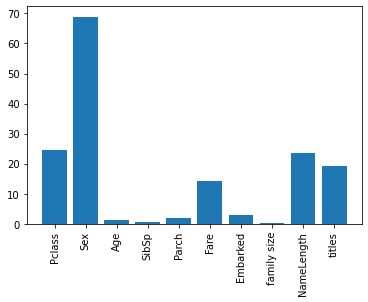

In [24]:
selector=SelectKBest(f_classif,k=5)
selector.fit(titanic[features],titanic['Survived'])
scores=-np.log10(selector.pvalues_)
plt.bar(range(len(features)),scores)
plt.xticks(range(len(features)),features,rotation='vertical')
plt.show()

In [25]:
features=['Pclass','Sex','Fare','NameLength','titles']
RF=RandomForestClassifier(random_state=1,n_estimators=50,min_samples_split=8,min_samples_leaf=4)

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
algorithms=[
    [GradientBoostingClassifier(random_state=1,n_estimators=25,max_depth=3),['Pclass',]]
]